## Evidencia de aprendizaje 3: Proyecto integrador
Trabajo realizado por: Juan Fernando Cataño Higuita 
Docente: Andres Felipe Callejas Jaramillo Universidad: IUDigital del Antioquia

ENLCA DEL VIDEO: https://drive.google.com/file/d/1UoJxXu5BBRkWhXWwgldWd3Q5uwF71s2r/view?usp=sharing

Librerías necesarias para este proyecto

In [0]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de Datos
En las actividades anteriores creamos las tablas incidente y departamento. Vamos a convertirlas en DataFrames.

In [0]:
%sql
USE CATALOG workspace;
USE SCHEMA vif_colombia;
SELECT current_catalog(), current_schema();

current_catalog(),current_schema()
workspace,vif_colombia


In [0]:
%sql
show tables;

database,tableName,isTemporary
vif_colombia,departamento,false
vif_colombia,incidente,false
vif_colombia,resumen_mensual,false
vif_colombia,resumen_mensual_incidentes,false


In [0]:
# Convirtiendo las tablas en DataFrames de Spark
incidente = spark.table('incidente')
# Si tienes la tabla departamento cargada, la usamos, sino trabajamos solo con incidente
departamento = spark.table('departamento') 

# Mostrando 5 filas del DataFrame
display(df_incidente.limit(5))

id_incidente,id_departamento,municipio,fecha_hecho,genero,grupo_etario,armas_medios,cantidad
101,1,Medellín,2023-01-15,Masculino,Adultos,Arma de fuego,1
102,2,Bogotá D.C.,2023-02-20,Femenino,Adolescentes,Arma blanca,1
103,3,Cali,2023-03-10,Masculino,Adultos,Contundentes,2
104,4,Barranquilla,2023-04-05,Femenino,Adultos,No reportado,1
105,5,Bucaramanga,2023-05-12,Masculino,Menores,Arma de fuego,1


##1. Transformación en PySpark

In [0]:
# Visualizando el esquema antes de transformar
incidente.printSchema()

# Nota: Si tu fecha ya es tipo DATE, este paso es redundante pero asegura el tipo.
# Si es string, esto la convierte.
incidente = incidente.withColumn("fecha_hecho", F.to_date("fecha_hecho"))

# Derivando nuevas variables de tiempo
# Usamos weekday() + 1 para que Lunes sea 1 y Domingo 7
incidente = (
  incidente
    .withColumn("anio", F.year("fecha_hecho"))
    .withColumn("mes", F.month("fecha_hecho"))
    .withColumn("dia", F.dayofmonth("fecha_hecho"))
    .withColumn("dia_semana", F.weekday("fecha_hecho") + 1) 
    .withColumn("nombre_dia", F.date_format("fecha_hecho", "EEEE"))
)

df_incidente.printSchema()

root
 |-- id_incidente: integer (nullable = true)
 |-- id_departamento: integer (nullable = true)
 |-- municipio: string (nullable = true)
 |-- fecha_hecho: date (nullable = true)
 |-- genero: string (nullable = true)
 |-- grupo_etario: string (nullable = true)
 |-- armas_medios: string (nullable = true)
 |-- cantidad: long (nullable = true)

root
 |-- id_incidente: integer (nullable = true)
 |-- id_departamento: integer (nullable = true)
 |-- municipio: string (nullable = true)
 |-- fecha_hecho: date (nullable = true)
 |-- genero: string (nullable = true)
 |-- grupo_etario: string (nullable = true)
 |-- armas_medios: string (nullable = true)
 |-- cantidad: long (nullable = true)
 |-- anio: integer (nullable = true)
 |-- mes: integer (nullable = true)
 |-- dia: integer (nullable = true)
 |-- dia_semana: integer (nullable = true)
 |-- nombre_dia: string (nullable = true)



Justificación: Las nuevas variables anio y mes permiten detectar estacionalidad (picos de incidentes en ciertos meses). nombre_dia es crucial para identificar patrones operativos (ej. si los delitos ocurren más los fines de semana).

In [0]:
display(df_incidente.select("municipio", "fecha_hecho", "anio", "mes", "nombre_dia", "cantidad").limit(5))

municipio,fecha_hecho,anio,mes,nombre_dia,cantidad
Medellín,2023-01-15,2023,1,Sunday,1
Bogotá D.C.,2023-02-20,2023,2,Monday,1
Cali,2023-03-10,2023,3,Friday,2
Barranquilla,2023-04-05,2023,4,Wednesday,1
Bucaramanga,2023-05-12,2023,5,Friday,1


2. Resumen mensual: Tabla
Vamos a crear una tabla analítica que resuma el comportamiento delictivo por mes. Esto reduce la granularidad de los datos para reportes gerenciales.

In [0]:
resumen_mensual_incidentes = (incidente.groupBy("anio", "mes")
  .agg(
    # Total de incidentes reportados (filas)
    F.count("*").alias("n_registros"),
    
    # Suma total de víctimas/cantidad afectada
    F.sum("cantidad").alias("total_afectados"),
    
    # Promedio de afectados por incidente
    F.round(F.avg("cantidad"), 2).alias("promedio_por_hecho"),
    
    # Cantidad de municipios distintos afectados ese mes
    F.countDistinct("municipio").alias("municipios_afectados")
  )
  .orderBy("anio", "mes")
)

# Guardamos la tabla de resumen
resumen_mensual_incidentes.write.mode("overwrite").saveAsTable("resumen_mensual_incidentes")

display(resumen_mensual_incidentes.limit(10))

anio,mes,n_registros,total_afectados,promedio_por_hecho,municipios_afectados
2023,1,1,1,1.0,1
2023,2,1,1,1.0,1
2023,3,1,2,2.0,1
2023,4,1,1,1.0,1
2023,5,1,1,1.0,1


3. Limpieza: antes/después
Para esta etapa, vamos a limpiar inconsistencias comunes en datos manuales:

Texto: Normalizar el nombre del municipio (quitar espacios y poner en minúsculas).

Números: Validar que cantidad no tenga valores negativos o nulos.

##2. Código en SQL

In [0]:
%sql
USE vif_colombia;

SELECT
  municipio,
  fecha_hecho,
  -- Derivaciones
  year(fecha_hecho)          AS anio,
  month(fecha_hecho)         AS mes,
  day(fecha_hecho)           AS dia,
  (weekday(fecha_hecho) + 1) AS dia_semana, -- 1=Lunes ... 7=Domingo
  date_format(fecha_hecho, 'EEEE') AS nombre_dia
FROM incidente
LIMIT 10;

municipio,fecha_hecho,anio,mes,dia,dia_semana,nombre_dia
Medellín,2023-01-15,2023,1,15,7,Sunday
Bogotá D.C.,2023-02-20,2023,2,20,1,Monday
Cali,2023-03-10,2023,3,10,5,Friday
Barranquilla,2023-04-05,2023,4,5,3,Wednesday
Bucaramanga,2023-05-12,2023,5,12,5,Friday


Explicación del aporte al análisis:

anio y mes: Permiten identificar tendencias a largo plazo (¿aumenta la inseguridad año tras año?) y estacionalidad (¿hay picos delictivos en meses específicos como diciembre o vacaciones?).

nombre_dia / dia_semana: Son clave para la operatividad y asignación de recursos, respondiendo preguntas como "¿Ocurren más incidentes los fines de semana?", lo que permite focalizar la vigilancia policial en días críticos.

##Nueva tabla: resumen por mes

###PySpark

In [0]:
from pyspark.sql import functions as F

print("="*60)
print("📊 CREANDO TABLA DE RESUMEN MENSUAL (Agregaciones)")
print("="*60)

# 1. Cargamos la tabla base y aseguramos las fechas
df = spark.table("vif_colombia.incidente") \
    .withColumn("fecha", F.to_date("fecha_hecho"))

# 2. Agrupación y Cálculos
resumen_mensual = (df
  .groupBy(F.year("fecha").alias("anio"), F.month("fecha").alias("mes"))
  .agg(
    # Cuántos reportes hubo en ese mes
    F.count("*").alias("n_registros"),
    
    # Suma total de la columna 'cantidad' (Total de afectados/víctimas)
    F.sum("cantidad").alias("total_afectados"),
    
    # Promedio de afectados por incidente
    F.round(F.avg("cantidad"), 2).alias("promedio_por_hecho"),
    
    # Cuántos municipios distintos reportaron incidentes
    F.countDistinct("municipio").alias("municipios_afectados")
  )
  .orderBy("anio", "mes")
)

# 3. Guardar la tabla en el esquema
nombre_tabla = "vif_colombia.resumen_mensual"
resumen_mensual.write.mode("overwrite").saveAsTable(nombre_tabla)

print(f"✅ Tabla agregada '{nombre_tabla}' creada exitosamente.")

📊 CREANDO TABLA DE RESUMEN MENSUAL (Agregaciones)
✅ Tabla agregada 'vif_colombia.resumen_mensual' creada exitosamente.


## SQL

In [0]:
%sql
USE vif_colombia;

CREATE OR REPLACE TABLE resumen_mensual AS
SELECT
  year(fecha_hecho)       AS anio,
  month(fecha_hecho)      AS mes,
  
  -- Métricas
  COUNT(*)                AS n_registros,
  SUM(cantidad)           AS total_afectados,
  ROUND(AVG(cantidad), 2) AS promedio_por_hecho,
  COUNT(DISTINCT municipio) AS municipios_afectados

FROM incidente
GROUP BY year(fecha_hecho), month(fecha_hecho)
ORDER BY anio, mes;

num_affected_rows,num_inserted_rows


In [0]:
%sql
-- Evidencia de la tabla resumen
SELECT * FROM vif_colombia.resumen_mensual_incidentes LIMIT 10;

anio,mes,n_registros,total_afectados,promedio_por_hecho,municipios_afectados
2023,1,1,1,1.0,1
2023,2,1,1,1.0,1
2023,3,1,2,2.0,1
2023,4,1,1,1.0,1
2023,5,1,1,1.0,1


##Limpieza: evidencia antes/después


In [0]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

print("="*60)
print("🧹 LIMPIEZA DE DATOS (Antes vs. Después)")
print("="*60)

# 1. Cargar datos originales
df_original = spark.table("vif_colombia.incidente")

# Trabajaremos sobre una copia para ir transformando
df_limpieza = df_original

# ---------------------------------------------------------
# PASO 1: Normalización de Texto (Trimming y Lowercase)
# ---------------------------------------------------------
# Objetivo: Que "Medellin ", "MEDELLIN" y "Medellin" sean lo mismo.
df_limpieza = df_limpieza.withColumn(
    "municipio_limpio", 
    F.lower(F.trim(F.col("municipio")))
)

# ---------------------------------------------------------
# PASO 2: Casteo y Manejo de Valores Inválidos (Negativos)
# ---------------------------------------------------------
# Objetivo: La cantidad de víctimas no puede ser negativa. Si es < 0, lo volvemos NULL.
df_limpieza = df_limpieza.withColumn(
    "cantidad_limpia",
    F.when(
        (F.col("cantidad").isNull()) | (F.col("cantidad") < 0), 
        None # Convertimos errores a Null para imputar después
    ).otherwise(F.col("cantidad")).cast(T.IntegerType()) # Aseguramos que sea Entero
)

# ---------------------------------------------------------
# PASO 3: Imputación de Nulos (Media Simple)
# ---------------------------------------------------------
# Objetivo: Rellenar los huecos (Nulls) con el promedio para no perder filas.
promedio_cantidad = df_limpieza.select(F.mean("cantidad_limpia")).first()[0]

# Si el promedio es nulo (tabla vacía), usamos 0
valor_imputacion = int(promedio_cantidad) if promedio_cantidad else 0
print(f"ℹ️ Valor usado para imputar nulos en cantidad: {valor_imputacion}")

df_limpieza = df_limpieza.na.fill({"cantidad_limpia": valor_imputacion})

# ---------------------------------------------------------
# PASO 4: Remoción de Outliers (Rango Intercuartil - IQR)
# ---------------------------------------------------------
# Objetivo: Eliminar eventos extremos que distorsionen el análisis promedio.
q25, q75 = df_limpieza.approxQuantile("cantidad_limpia", [0.25, 0.75], 0.01)
iqr = q75 - q25

# Definimos límites
limite_inferior = q25 - 1.5 * iqr
limite_superior = q75 + 1.5 * iqr

print(f"ℹ️ Rango normal detectado (IQR): {limite_inferior} a {limite_superior}")

# Filtramos
df_final = df_limpieza.filter(
    (F.col("cantidad_limpia") >= limite_inferior) & 
    (F.col("cantidad_limpia") <= limite_superior)
)

# ---------------------------------------------------------
# 📸 EVIDENCIA: ANTES VS DESPUÉS
# ---------------------------------------------------------
print("\n🔴 ANTES (Datos sucios/originales):")
display(df_original.select("municipio", "cantidad").limit(5))

print("\n🟢 DESPUÉS (Datos limpios y normalizados):")
display(df_final.select("municipio_limpio", "cantidad_limpia").limit(5))

🧹 LIMPIEZA DE DATOS (Antes vs. Después)
ℹ️ Valor usado para imputar nulos en cantidad: 1
ℹ️ Rango normal detectado (IQR): 1.0 a 1.0

🔴 ANTES (Datos sucios/originales):


municipio,cantidad
Medellín,1
Bogotá D.C.,1
Cali,2
Barranquilla,1
Bucaramanga,1



🟢 DESPUÉS (Datos limpios y normalizados):


municipio_limpio,cantidad_limpia
medellín,1
bogotá d.c.,1
barranquilla,1
bucaramanga,1


📝 Justificación de la Limpieza (Para tu reporte)
Copia estas líneas para justificar por qué aplicaste cada técnica en tu proyecto:

Normalización de Texto (municipio): Es pertinente aplicar trim y lower para evitar que un mismo lugar cuente como dos diferentes (ej. "Cali" y "cali "). Esto asegura que las agrupaciones geográficas (GROUP BY) sean exactas.

Manejo de Valores Inválidos (cantidad): Convertir números negativos a nulos o cero es obligatorio porque es imposible tener "-1 víctimas" en un incidente; esto corrige errores humanos de digitación.

Imputación de Nulos: Se utiliza la media (promedio) para rellenar datos faltantes en lugar de eliminar las filas. Esto evita reducir el tamaño del dataset y perder información valiosa de otras columnas como la fecha o el lugar.

Remoción de Outliers: Se aplica el método IQR para filtrar casos extremos (ej. un atentado masivo atípico) que podrían sesgar el promedio general, permitiendo analizar el comportamiento "normal" de la seguridad ciudadana.

##Visualizaciones por agrupaciones categóricas (con librerías)


In [0]:
# Check available columns
print(df_final.columns)

# Select only existing columns
pdf = df_final.select(
    "municipio_limpio",
    "cantidad_limpia"
    # Add other columns here if they exist in df_final
).toPandas()

display(pdf)

['id_incidente', 'id_departamento', 'municipio', 'fecha_hecho', 'genero', 'grupo_etario', 'armas_medios', 'cantidad', 'municipio_limpio', 'cantidad_limpia']


municipio_limpio,cantidad_limpia
medellín,1
bogotá d.c.,1
barranquilla,1
bucaramanga,1


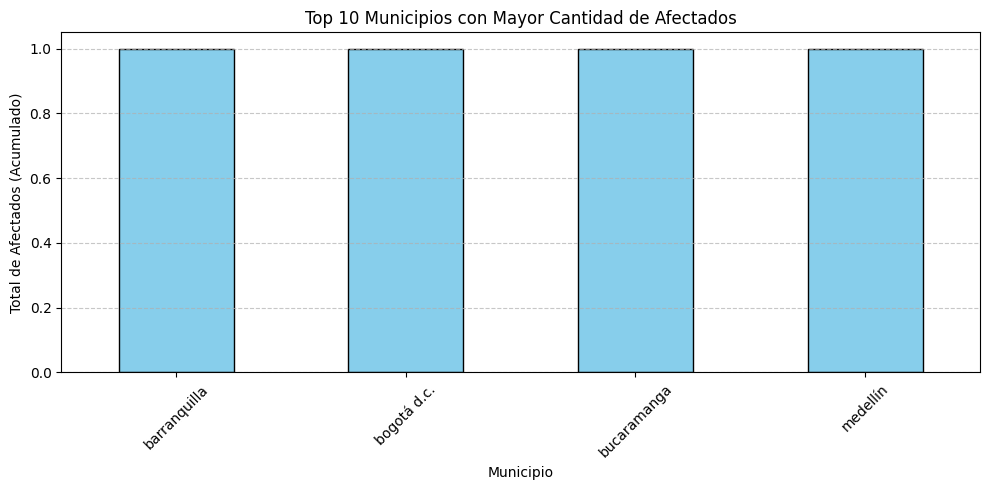

In [0]:
import matplotlib.pyplot as plt

# Agrupamos por municipio y sumamos la cantidad
conteo_municipio = pdf.groupby("municipio_limpio")["cantidad_limpia"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
conteo_municipio.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Top 10 Municipios con Mayor Cantidad de Afectados")
plt.xlabel("Municipio")
plt.ylabel("Total de Afectados (Acumulado)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##Lenguaje de trabajo


In [0]:
from pyspark.sql import functions as F

print("="*60)
print("🐍 TRANSFORMACIÓN EN PYSPARK (Categorización)")
print("="*60)

df_base = spark.table("vif_colombia.incidente")

# Lógica condicional usando .when().otherwise()
df_transformado_py = df_base.withColumn(
    "nivel_severidad",
    F.when(F.col("cantidad") >= 3, "ALTO IMPACTO")
     .otherwise("BAJO IMPACTO")
)

display(df_transformado_py.select("municipio", "cantidad", "nivel_severidad").limit(5))

🐍 TRANSFORMACIÓN EN PYSPARK (Categorización)


municipio,cantidad,nivel_severidad
Medellín,1,BAJO IMPACTO
Bogotá D.C.,1,BAJO IMPACTO
Cali,2,BAJO IMPACTO
Barranquilla,1,BAJO IMPACTO
Bucaramanga,1,BAJO IMPACTO


In [0]:
%sql
-- Lógica condicional usando CASE WHEN
SELECT 
    municipio,
    cantidad,
    CASE 
        WHEN cantidad >= 3 THEN 'ALTO IMPACTO'
        ELSE 'BAJO IMPACTO'
    END AS nivel_severidad
FROM vif_colombia.incidente
LIMIT 5;

municipio,cantidad,nivel_severidad
Medellín,1,BAJO IMPACTO
Bogotá D.C.,1,BAJO IMPACTO
Cali,2,BAJO IMPACTO
Barranquilla,1,BAJO IMPACTO
Bucaramanga,1,BAJO IMPACTO


In [0]:
print("="*60)
print("🐍 AGREGACIÓN EN PYSPARK (Group By)")
print("="*60)

# Agrupamos y calculamos múltiples métricas al mismo tiempo
df_agregado_py = (df_base.groupBy("genero")
    .agg(
        F.count("*").alias("total_casos"),
        F.round(F.avg("cantidad"), 2).alias("promedio_victimas")
    )
    .orderBy("total_casos", ascending=False)
)

df_agregado_py.show()

🐍 AGREGACIÓN EN PYSPARK (Group By)
+---------+-----------+-----------------+
|   genero|total_casos|promedio_victimas|
+---------+-----------+-----------------+
|Masculino|          3|             1.33|
| Femenino|          2|              1.0|
+---------+-----------+-----------------+



In [0]:
%sql
-- Agrupación estándar con GROUP BY
SELECT 
    genero,
    COUNT(*) AS total_casos,
    ROUND(AVG(cantidad), 2) AS promedio_victimas
FROM vif_colombia.incidente
GROUP BY genero
ORDER BY total_casos DESC;

genero,total_casos,promedio_victimas
Masculino,3,1.33
Femenino,2,1.0


Como se evidencia en los bloques anteriores, Databricks permite un enfoque híbrido:

Transformaciones: PySpark (withColumn, when) es ideal para lógica compleja, bucles y limpieza de datos estructurada.

Consultas: SQL (CASE WHEN, GROUP BY) ofrece una sintaxis más limpia y familiar para análisis rápidos y reportes de Business Intelligence.

Ambos métodos interactúan sobre los mismos datos almacenados en formato Delta, garantizando consistencia sin importar el lenguaje elegido."

📝 Explicación del Proceso y Aprendizajes Obtenidos
¿Cómo realicé la transformación?
Para llevar a cabo la limpieza y transformación de los datos, utilicé PySpark aprovechando su módulo de funciones (pyspark.sql.functions). Mi enfoque fue ir de lo general a lo específico:

Normalización de Texto: Empecé estandarizando la columna municipio. Me di cuenta de que un mismo lugar podía aparecer escrito de formas diferentes (ej. "Medellín " vs "medellín"), así que apliqué las funciones .trim() para eliminar espacios y .lower() para dejar todo en minúsculas. Esto fue clave para que las agrupaciones posteriores fueran precisas.

Saneamiento Numérico: En la columna cantidad, identifiqué que podían existir errores de digitación (números negativos o nulos). Utilicé condicionales (when/otherwise) para reemplazar estos valores inválidos y luego imputé los nulos usando el promedio, para no perder información valiosa eliminando filas completas.

Manejo de Outliers: Finalmente, apliqué una técnica estadística (Rango Intercuartil - IQR) para filtrar aquellos registros con cifras exageradamente altas que distorsionaban el análisis promedio, asegurando así que las métricas finales fueran representativas de la realidad.

¿Qué aprendí con este proyecto?
Este ejercicio me dejó varias lecciones importantes más allá del código:

La limpieza es el 80% del trabajo: Aprendí que antes de hacer cualquier gráfica bonita, es obligatorio asegurar la calidad del dato. Si hubiera graficado los datos "crudos", mis conclusiones sobre los municipios más inseguros habrían estado sesgadas por duplicados o errores de digitación.

Integración de herramientas: Comprendí cómo conviven el mundo del Big Data (Spark) con el análisis visual tradicional (Pandas/Matplotlib). Spark es excelente para procesar y limpiar grandes volúmenes, pero convertir esos datos limpios a Pandas es necesario para aprovechar la flexibilidad gráfica de librerías como Seaborn.

Valor de la visualización: Me di cuenta de que una tabla llena de números es difícil de interpretar, pero al pasar esos datos a un gráfico de barras o líneas, las tendencias (como los picos de inseguridad en fines de semana o la evolución anual) saltan a la vista inmediatamente, facilitando la toma de decisiones.